Authors : Thomas Berthomier and Loann Patérour
Date: 16th January 2025

# Introduction

* Objective: 
In this project, we aim to analyze the bone marrow transcriptome to be able to classify different bone marrow neoplasia based on the expression of 60 000 genes for 5406 patients. We also aim to identify important features (genes and eventually pathways) associated with each bone marrow neoplasia. 

* Background: 
Bone marrow plays a critical role in blood cell formation, and abnormalities in its function can lead to hematologic disorders called neoplasia. Transcriptome profiling allows us to explore gene expression in bone marrow and classify them based on these transcriptomic data.

* Data: 
We use transcriptomic data from a cohort of bone marrow samples associated with their diseases that has been diagnosed. The labels correspond to the category of blood cancer in which the diagnosis is classidied. Some metadata information on the patients are also available in a clinical_data.tsv file.

Table of content :
1. Visualization of the scaled data  
    1.1 Visualization of the structure of the main dataframe  
    1.2 Visualization using unsupervised methods (PCA, UMAP)  
2. Visualization of predictive models performance (Logistic regression, SVM, MLP)
3. Visualization of the performances for the "best" model
4. Feature importance analysis on the best model

In [1]:
#Required importation:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import Data, load_data_comparison
from best_model import BestModel
from model_selection import nested_cross_val
from viz_raw_data import compare_performance
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
seed = 123

# 1. Visualization of the preprocessed data using unsupervised methods (PCA, UMAP)

## 1.1 Visualization of the structure of the main dataframe


Before using predicting modeling algorithm, let's explore the dataset to understand the distribution of gene expression values and identify any patterns in the data that could be used to group the patients based on their neoplasia.

In [2]:
data = Data()

Loading the merged dataframe...
Done!
Loading clinical data...
Done!
Adding categories to the dataframe...
Creating attributes for scikit-learn...
Data loading completed!


<Axes: xlabel='0'>

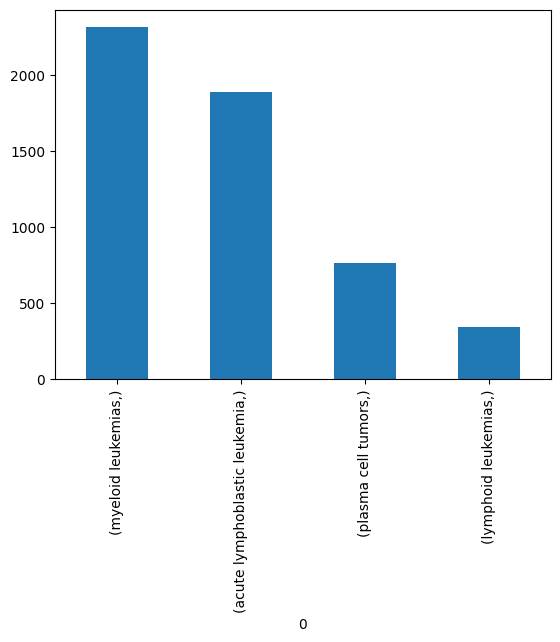

In [3]:
#Bar plot of the number of occurences of each label
pd.DataFrame(data.y).value_counts().plot(kind = "bar")

The data is unbalanced for the different labels. It has to be taken into account for the different models tested and their performances associated, using some weighted or oversampled models.

## 1.2 Visualization using unsupervised methods (PCA, UMAP) 

Plot saved as ../plots/PCA_transcriptome


(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'PCA of the transcriptomes'}, xlabel='PC1 (13.02%)', ylabel='PC2 (9.09%)'>)

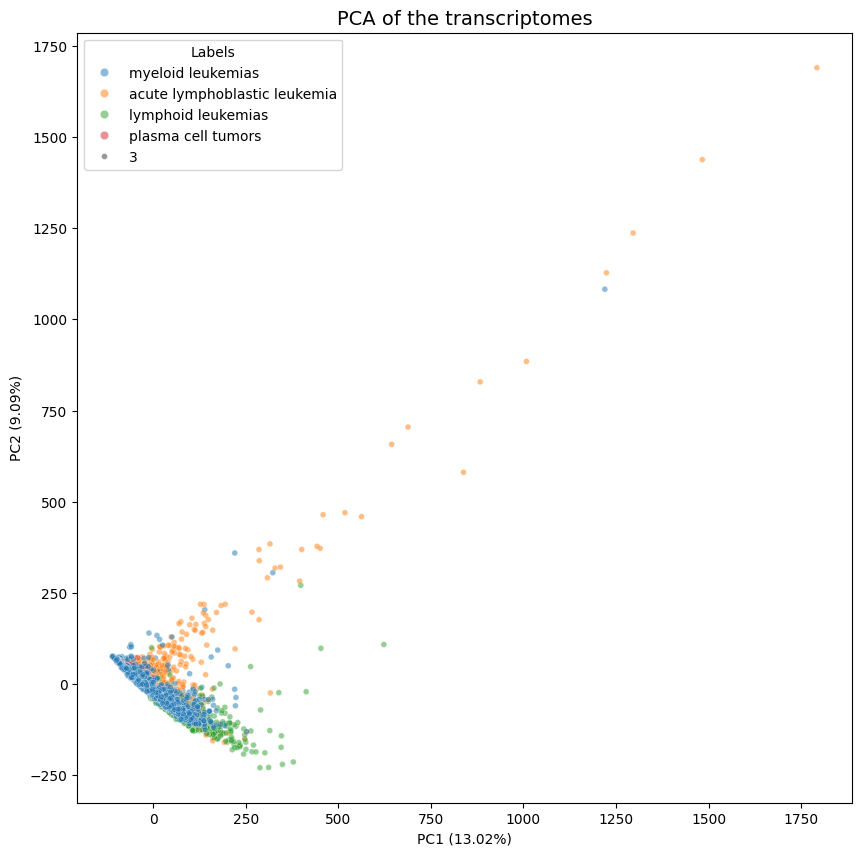

In [4]:
#PCA
data.plot_PCA()

It is possible to see that the two first principal components of the PCA explained respectively (around 13% and 9% of the variance). The first two components separate unefficiently the different neoplasia. But interestingly, ALL (for Acute Lymphoblastic Leukemia) is a bit more separated from the other neoplasia.

/shared/home/tberthom/.local/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Plot saved as UMAP_transcriptome


(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'UMAP of the transcriptomes'}, xlabel='UMAP 1', ylabel='UMAP 2'>)

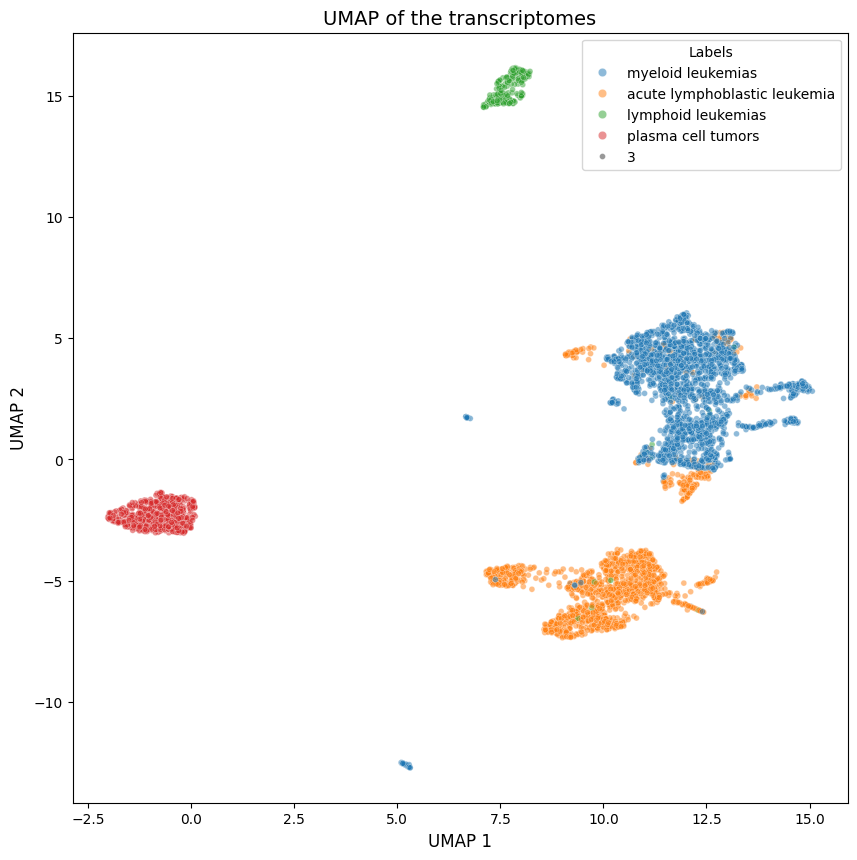

In [5]:
#UMAP
data.plot_UMAP(seed)

It is possible to see that the labels are well separated except for two classes: ALL (Acute Lymphoblastic Leukemia) and AML (Acute Myeloid Leukemia). For these two neoplasia it seems that a part of the ALL as been either misqualified or it exists some subtypes of the ALL that are transcriptionally closer to the AML.
Considering these results, it might be possible that the different machine learning models perform quite well.

# 2. Visualization of predictive models performance (Logistic regression, SVM, MLP)

* Models tested:

Logistic Regression with unweighted classes (not corrected for unbalanced data)  
Logistic Regression with weighted classes (corrected for unbalanced data)
Logistic Regression with oversampling
SVM with unweighted classes  
SVM with weighted classes  
SVM with oversampling
Classical MLP  
Oversampled MLP 
For oversampled models, the minority classes have been artificially increased (over-sampled) to create a balanced dataset. It has been done using SMOTE (Synthetic Minority Over-sampling Technique) which generates new "synthetic" samples for the minority class by interpolating between existing examples.  

* Hyperparameter tested : 

for Logistic Regression :   
'penalty' : 'l2',                                                                 
'solver' : 'liblinear',                                                             
'alpha' : 0.001                                                        

for SVM :   
'kernel' : 'linear',                                       
'C' : 1

for MLP:  
'hidden_layer_sizes': [(500,), (1000,), (1000,500)],  
'activation': ['relu', 'logistic'],                      
'learning_rate_init': [0.001, 0.01],               
'batch_size': [32]    

Plot saved as ../plots/compare_perf


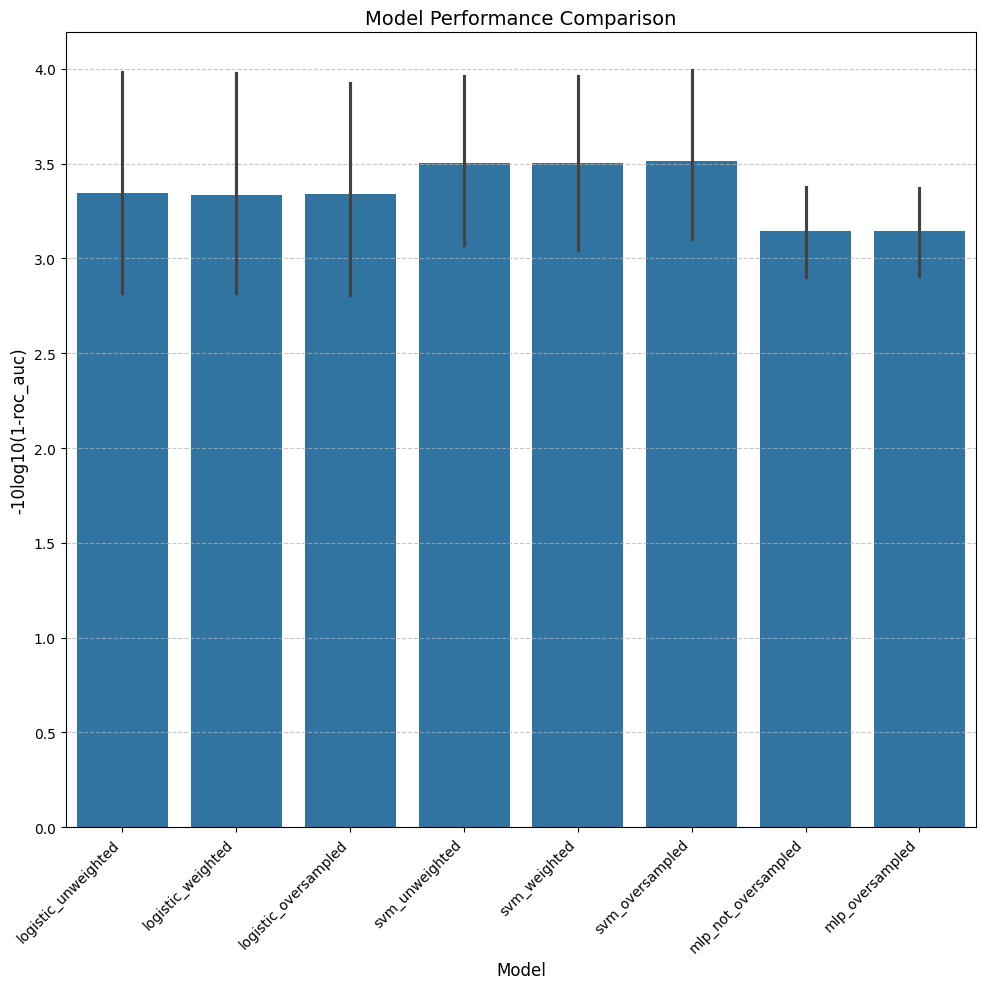

In [6]:
#ROC-AUC score comparison for the different models 
performance_df = load_data_comparison()
compare_performance(performance_df, save_path = "../plots/compare_perf")

In [7]:
performance_df.groupby("Model").agg({"-10log10(1-roc_auc)": "mean"})["-10log10(1-roc_auc)"]\
    .sort_values(ascending = False)

Model
svm_oversampled         3.512072
svm_unweighted          3.505104
svm_weighted            3.505104
logistic_unweighted     3.342794
logistic_oversampled    3.339357
logistic_weighted       3.335526
mlp_not_oversampled     3.145275
mlp_oversampled         3.145275
Name: -10log10(1-roc_auc), dtype: float64

SVM with oversampling is the best model but there is probably no statistical significance as each model display a very high performance and the residual error could possibly due to misslabeling.

For the MLP model, the absence of dropout regularization to prevent over-fitting may explain why this model "under-perform" in comparaison to the other models.
The grid search performed in this model may also not have been enough exhaustive to really find the best set of hyperparameters

# 3. Visualization of the performances for the "best" model

For evaluation of the performance, we have chosen the model with highest ROC-AUC score for classification.

In [8]:
best_model = BestModel(SVC, {'kernel' : 'linear','C' : 1}, oversampling = True, seed = seed)
best_model.train_model(data.X_train, data.y_train)
best_model.evaluate_model(data.X_test, data.y_test)

F1-Score: 0.996
ROC-AUC Score (OVR Weighted) : 0.999


/shared/home/tberthom/.local/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/shared/home/tberthom/.local/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Plot saved as UMAP_transcriptome


(<Figure size 2000x1000 with 2 Axes>,
 array([<Axes: title={'center': 'Target values'}, xlabel='UMAP 1', ylabel='UMAP 2'>,
        <Axes: title={'center': 'Predicted values'}, xlabel='UMAP 1', ylabel='UMAP 2'>],
       dtype=object))

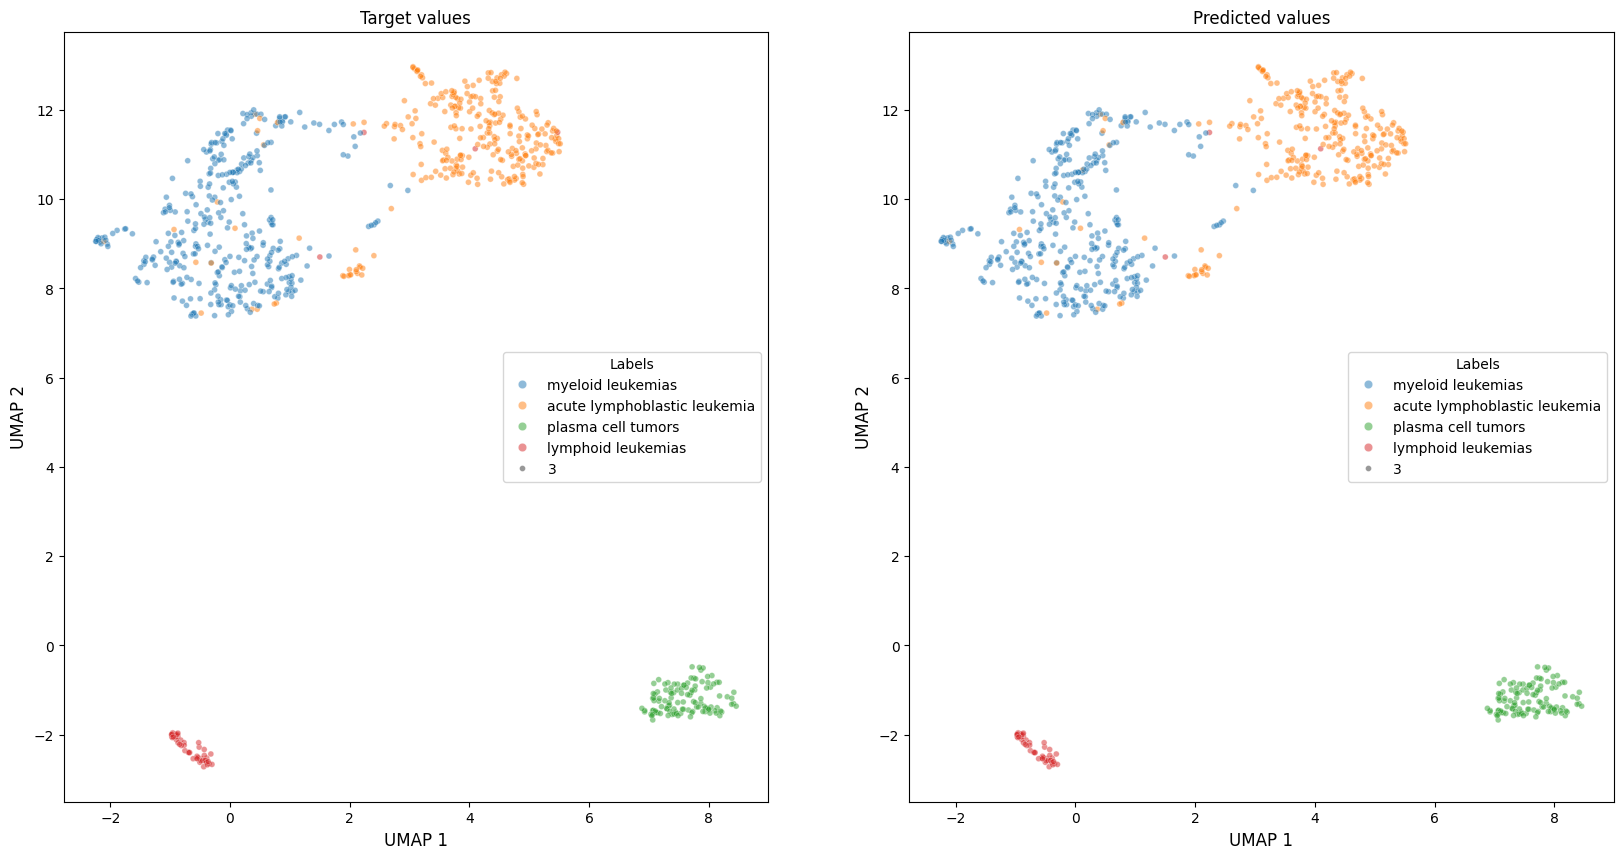

In [9]:
#UMAP with predicted labels
best_model.side_by_side_UMAP(data.X_test, data.y_test)

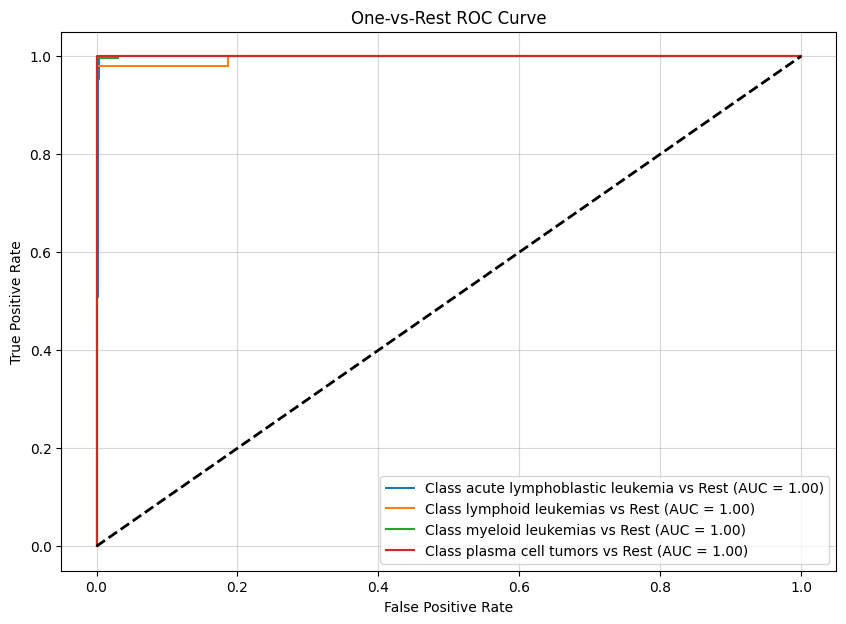

In [10]:
#ROC-AUC curve OVR
best_model.ROC_AUC_curve(data.X_test, data.y_test)

# 4. Feature importance analysis on the best model

For feature analysis, we have chosen the logistic regression with ridge correction as we can interpret the size of the coefficient as the importance of the feature and the sign as the direction of impact.

In [11]:
feature_model = BestModel(LogisticRegression, {'penalty': 'l2', 'solver':'liblinear'}, seed = seed)
feature_model.train_model(data.X_train, data.y_train)
feature_model.evaluate_model(data.X_test, data.y_test)

F1-Score: 0.995
ROC-AUC Score (OVR Weighted) : 0.999


/shared/ifbstor1/home/tberthom/hemato/code/best_model.py:146: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/shared/ifbstor1/home/tberthom/hemato/code/best_model.py:146: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/shared/ifbstor1/home/tberthom/hemato/code/best_model.py:146: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/shared/ifbstor1/home/tberthom/hemato/code/best_model.py:146: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklab

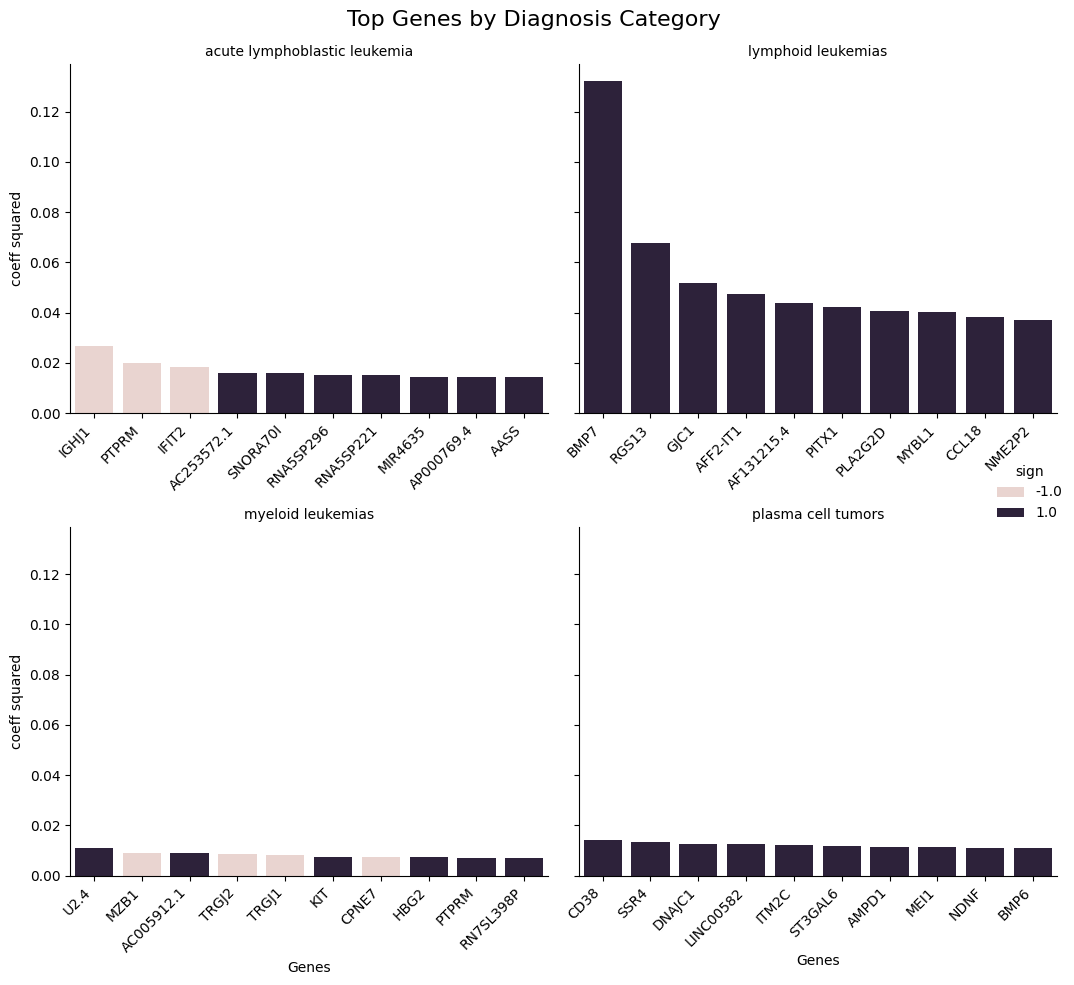

In [12]:
#Feature importance plot 
feature_model.process_genes_coeff(data=data)
feature_model.plot_top_genes(n_genes=10)

# Conclusion: 

The models tested here seem to be particularly efficient in classifying the different samples among the four classes of bone marrow neoplasia. 

It could be intesting to look more closely at the gene expression patterns associated with the feature importance analysis, it could help to uncover potential biomarkers for these neoplasia.